In [24]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

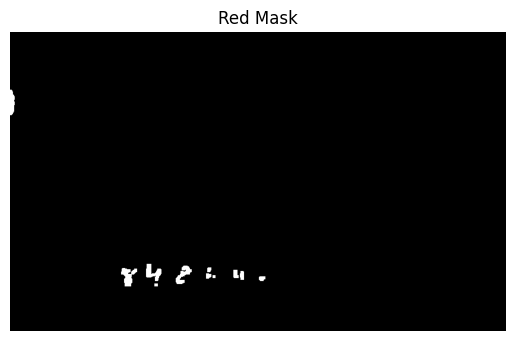

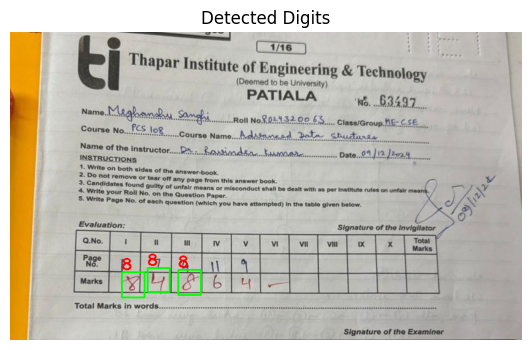

All Detected Digits: [8, 8, 8]


In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_red_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([179, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3, 3), np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    red_mask = cv2.dilate(red_mask, kernel, iterations=2)
    return red_mask

def extract_digits_from_mask(image, mask, model):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    debug_img = image.copy()
    digit_entries = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 10 < w < 80 and 20 < h < 100:
            x1, y1 = max(x - 5, 0), max(y - 5, 0)
            x2, y2 = min(x + w + 5, image.shape[1]), min(y + h + 5, image.shape[0])
            roi = image[y1:y2, x1:x2]
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
            norm = resized.astype("float32") / 255.0
            input_img = np.expand_dims(norm, axis=(0, -1))
            pred = model.predict(input_img, verbose=0)
            digit = int(np.argmax(pred))
            digit_entries.append((x, digit))

            cv2.rectangle(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(debug_img, str(digit), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    digit_entries.sort(key=lambda x: x[0])  # sort left to right
    digits = [d[1] for d in digit_entries]

    # Show result
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Digits")
    plt.axis("off")
    plt.show()

    return digits

def extract_all_red_digits(image_path, model_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    model = load_model(model_path)
    red_mask = extract_red_mask(image)

    # Show red mask
    plt.imshow(red_mask, cmap="gray")
    plt.title("Red Mask")
    plt.axis("off")
    plt.show()

    return extract_digits_from_mask(image, red_mask, model)

# Run
image_path = "test1.jpeg"
model_path = "red_digit_model.h5"

digits = extract_all_red_digits(image_path, model_path)
print("All Detected Digits:", digits)
